In [1]:
# !pip install -q pytorchvideo evaluate

In [2]:
# pip install -q pyarrow==14.0.1

In [3]:
# pip install -q transformers --upgrade

In [4]:
# pip install -q torch==2.0.1 torchvision==0.15.2 --extra-index-url https://download.pytorch.org/whl/cu118 xformers==0.0.21

# **Data Collection and Aggregation**

In [5]:
import os
import pandas as pd

root_path = "/kaggle/input/nepali-sign-langg"
folder_list = os.listdir(root_path)
label_list = [path for path in folder_list if not path.endswith((".csv"))]

total_df = pd.read_csv(os.path.join(root_path,"train.csv"))

total_df.reset_index(drop = True, inplace = True)
total_df['label'].value_counts()

label
म घर मा धेरै काम गर्छु ।          16
म संग धेरै पैसा छैन ।             12
मेरो साथी हरु भक्तपुर मा छन् ।    12
मेरो धेरै साथी हरु छन् ।           8
मेरो घर भक्तपुर मा छ ।             8
Name: count, dtype: int64

# **Data Splitting**

In [6]:
from sklearn.model_selection import train_test_split

def correct_file_path(file_name: str, root_path: str):
    return os.path.join(root_path, file_name)

def preprocess_meta_df(df, root_path, label2id):
    df.rename(columns={"video_name": "video_path"}, inplace=True)
    df['video_path'] = df['video_path'].apply(lambda x: correct_file_path(x, root_path))
#     df['label'] = df['label'].apply(lambda x: label2id[x])
    df['label'] = df['label']
    
    return df

train_meta_df, test_meta_df = train_test_split(total_df, test_size=0.2, stratify=total_df['label'], random_state=42)

label_list = list(set(train_meta_df['label']))
class_labels = sorted(label_list)
label2id = {label: i for i, label in enumerate(class_labels)}
id2label = {i: label for label, i in label2id.items()}

print(f"Unique classes: {list(label2id.keys())}.")

train_meta_df = preprocess_meta_df(train_meta_df, root_path, label2id)
test_meta_df = preprocess_meta_df(test_meta_df, root_path, label2id)

print("Splitted data:", len(train_meta_df), len(test_meta_df))

Unique classes: ['म घर मा धेरै काम गर्छु ।', 'म संग धेरै पैसा छैन ।', 'मेरो घर भक्तपुर मा छ ।', 'मेरो धेरै साथी हरु छन् ।', 'मेरो साथी हरु भक्तपुर मा छन् ।'].
Splitted data: 44 12


#  **Model Selection and Design**

## Preparing Configuration for the final Model

In [7]:
import torch
def get_config():
    return {
        "batch_size": 1,
        "num_epochs": 2,
        "lr": 10**-4,
        "seq_len": 784,
        "d_model": 768,
        "lang_tgt": "ne",
        "model_folder": "weights",
        "model_basename": "tmodel_",
        "preload": "latest",
        "tokenizer_file": "tokenizer_{0}.json",
        "experiment_name": "/content/drive/MyDrive/English2Nepali/runs"
        # "experiment_name": "/content/drive/MyDrive/translation/runs"
    }

config=get_config()
device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

## Pre-trained Encoder Model (Video Vision Transformer)

In [8]:
import pytorchvideo.data
from torch.utils.data import Dataset
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification
from transformers import VivitImageProcessor, VivitModel, VivitForVideoClassification

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)

model_checkpoint = "google/vivit-b-16x2-kinetics400"
image_processor = VivitImageProcessor.from_pretrained(model_checkpoint)

# model = VivitForVideoClassification.from_pretrained(model_checkpoint)
vivit_model=VivitModel.from_pretrained(model_checkpoint)

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of VivitModel were not initialized from the model checkpoint at google/vivit-b-16x2-kinetics400 and are newly initialized: ['vivit.pooler.dense.bias', 'vivit.pooler.dense.weight']
You should probably TRAIN this model on a down-str

In [9]:
vivit_model

VivitModel(
  (embeddings): VivitEmbeddings(
    (patch_embeddings): VivitTubeletEmbeddings(
      (projection): Conv3d(3, 768, kernel_size=(2, 16, 16), stride=(2, 16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): VivitEncoder(
    (layer): ModuleList(
      (0-11): 12 x VivitLayer(
        (attention): VivitAttention(
          (attention): VivitSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): VivitSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): VivitIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (dropout): D

## Don't Need the Final Pooler Layer

In [10]:
#Replace pooler layer with the identity function, it just returns what it gets

class Identity(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return x

# model.classifier=Identity()
# model.classifier=torch.nn.Linear(768,5)

# patch size of 32*32
vivit_model.config.tubelet_size=[2,32,32]

# 6 encoder block stacks
vivit_model.config.num_hidden_layers=12

vivit_model=VivitModel(vivit_model.config)

vivit_model.pooler=Identity()

In [11]:
vivit_model

VivitModel(
  (embeddings): VivitEmbeddings(
    (patch_embeddings): VivitTubeletEmbeddings(
      (projection): Conv3d(3, 768, kernel_size=(2, 32, 32), stride=(2, 32, 32))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): VivitEncoder(
    (layer): ModuleList(
      (0-11): 12 x VivitLayer(
        (attention): VivitAttention(
          (attention): VivitSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): VivitSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): VivitIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (dropout): D

## Custom Decoder Model

In [12]:
import math

class InputEmbeddings(torch.nn.Module):

    def __init__(self, d_model: int=768, vocab_size: int=20) -> None:
        super().__init__()
        self.d_model = d_model
        self.vocab_size = vocab_size
        self.embedding = torch.nn.Embedding(vocab_size, d_model)

    def forward(self, x):
        # (batch, seq_len) --> (batch, seq_len, d_model)
        # Multiply by sqrt(d_model) to scale the embeddings according to the paper
        return self.embedding(x) * math.sqrt(self.d_model)


class PositionalEncoding(torch.nn.Module):

    def __init__(self, d_model: int=768, seq_len: int=3136, dropout: float=0.1) -> None:
        super().__init__()
        self.d_model = d_model
        self.seq_len = seq_len
        self.dropout = torch.nn.Dropout(dropout)
        # Create a matrix of shape (seq_len, d_model)
        pe = torch.zeros(seq_len, d_model)
        # Create a vector of shape (seq_len)
        position = torch.arange(
            0, seq_len, dtype=torch.float).unsqueeze(1)  # (seq_len, 1)
        # Create a vector of shape (d_model)
        div_term = torch.exp(torch.arange(0, d_model, 2).float(
        ) * (-math.log(10000.0) / d_model))  # (d_model / 2)
        # Apply sine to even indices
        # sin(position * (10000 ** (2i / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        # Apply cosine to odd indices
        # cos(position * (10000 ** (2i / d_model))
        pe[:, 1::2] = torch.cos(position * div_term)
        # Add a batch dimension to the positional encoding
        pe = pe.unsqueeze(0)  # (1, seq_len, d_model)
        # Register the positional encoding as a buffer
        self.register_buffer('pe', pe)

    def forward(self, x):
        # (batch, seq_len, d_model)
        x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False)
        return self.dropout(x)
    
    
    
class MultiHeadAttentionBlock(torch.nn.Module):

    def __init__(self, d_model: int=768, h: int=8, dropout: float=0.1) -> None:
        super().__init__()
        self.d_model = d_model  # Embedding vector size
        self.h = h  # Number of heads
        # Make sure d_model is divisible by h
        assert d_model % h == 0, "d_model is not divisible by h"

        self.d_k = d_model // h  # Dimension of vector seen by each head
        self.w_q = torch.nn.Linear(d_model, d_model, bias=False)  # Wq
        self.w_k = torch.nn.Linear(d_model, d_model, bias=False)  # Wk
        self.w_v = torch.nn.Linear(d_model, d_model, bias=False)  # Wv
        self.w_o = torch.nn.Linear(d_model, d_model, bias=False)  # Wo
        self.dropout = torch.nn.Dropout(dropout)

    @staticmethod
    def attention(query, key, value, mask, dropout: torch.nn.Dropout):
        d_k = query.shape[-1]
        # Just apply the formula from the paper
        # (batch, h, seq_len, d_k) --> (batch, h, seq_len, seq_len)
        attention_scores = (query @ key.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            # Write a very low value (indicating -inf) to the positions where mask == 0
            attention_scores.masked_fill_(mask == 0, -1e9)
        # (batch, h, seq_len, seq_len) # Apply softmax
        attention_scores = attention_scores.softmax(dim=-1)
        if dropout is not None:
            attention_scores = dropout(attention_scores)
        # (batch, h, seq_len, seq_len) --> (batch, h, seq_len, d_k)
        # return attention scores which can be used for visualization
        return (attention_scores @ value), attention_scores

    def forward(self, q, k, v, mask):
        # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        query = self.w_q(q)
        # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        key = self.w_k(k)
        # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        value = self.w_v(v)

        # (batch, seq_len, d_model) --> (batch, seq_len, h, d_k) --> (batch, h, seq_len, d_k)
        query = query.view(
            query.shape[0], query.shape[1], self.h, self.d_k).transpose(1, 2)
        key = key.view(key.shape[0], key.shape[1],
                       self.h, self.d_k).transpose(1, 2)
        value = value.view(
            value.shape[0], value.shape[1], self.h, self.d_k).transpose(1, 2)

        # Calculate attention
        x, self.attention_scores = MultiHeadAttentionBlock.attention(
            query, key, value, mask, self.dropout)

        # Combine all the heads together
        # (batch, h, seq_len, d_k) --> (batch, seq_len, h, d_k) --> (batch, seq_len, d_model)
        x = x.transpose(1, 2).contiguous().view(
            x.shape[0], -1, self.h * self.d_k)

        # Multiply by Wo
        # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        return self.w_o(x)
    

class LayerNormalization(torch.nn.Module):

    def __init__(self, features: int, eps: float = 10**-6) -> None:
        super().__init__()
        self.eps = eps
        # alpha is a learnable parameter
        self.alpha = torch.nn.Parameter(torch.ones(features))
        # bias is a learnable parameter
        self.bias = torch.nn.Parameter(torch.zeros(features))

    def forward(self, x):
        # x: (batch, seq_len, hidden_size)
        # Keep the dimension for broadcasting
        mean = x.mean(dim=-1, keepdim=True)  # (batch, seq_len, 1)
        # Keep the dimension for broadcasting
        std = x.std(dim=-1, keepdim=True)  # (batch, seq_len, 1)
        # eps is to prevent dividing by zero or when std is very small
        return self.alpha * (x - mean) / (std + self.eps) + self.bias


class FeedForwardBlock(torch.nn.Module):

    def __init__(self, d_model: int, d_ff: int, dropout: float) -> None:
        super().__init__()
        self.linear_1 = torch.nn.Linear(d_model, d_ff)  # w1 and b1
        self.dropout = torch.nn.Dropout(dropout)
        self.linear_2 = torch.nn.Linear(d_ff, d_model)  # w2 and b2

    def forward(self, x):
        # (batch, seq_len, d_model) --> (batch, seq_len, d_ff) --> (batch, seq_len, d_model)
        return self.linear_2(self.dropout(torch.relu(self.linear_1(x))))


class ResidualConnection(torch.nn.Module):

    def __init__(self, features: int, dropout: float) -> None:
        super().__init__()
        self.dropout = torch.nn.Dropout(dropout)
        self.norm = LayerNormalization(features)

    # many transformer implmentation also do like this--> normalize the input + positional embedding, then apply mhsa and add skip connection.
    # here sublayer is MHSA
    def forward(self, x, sublayer):
      return x + self.dropout(self.norm(sublayer(x)))



class DecoderBlock(torch.nn.Module):

    def __init__(self, features: int, self_attention_block: MultiHeadAttentionBlock, cross_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        super().__init__()
        self.self_attention_block = self_attention_block
        self.cross_attention_block = cross_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = torch.nn.ModuleList(
            [ResidualConnection(features, dropout) for _ in range(3)])

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        x = self.residual_connections[0](
            x, lambda x: self.self_attention_block(x, x, x, tgt_mask))
        x = self.residual_connections[1](x, lambda x: self.cross_attention_block(
            x, encoder_output, encoder_output, src_mask))
        x = self.residual_connections[2](x, self.feed_forward_block)
        return x


class Decoder(torch.nn.Module):

    def __init__(self, features: int, layers: torch.nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization(features)

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, encoder_output, src_mask, tgt_mask)
        return self.norm(x)


class ProjectionLayer(torch.nn.Module):

    def __init__(self, d_model, vocab_size) -> None:
        super().__init__()
        self.proj = torch.nn.Linear(d_model, vocab_size)

    def forward(self, x) -> None:
        # (batch, seq_len, d_model) --> (batch, seq_len, vocab_size)
        return self.proj(x)

## Building Video2Text Transformer Architecture

In [13]:
class Video2Text(torch.nn.Module):

    def __init__(self, encoder, decoder: Decoder, tgt_embed: InputEmbeddings, tgt_pos: PositionalEncoding, projection_layer: ProjectionLayer) -> None:
        super().__init__()
        self.video_encoder = encoder
        self.decoder = decoder
        self.tgt_embed = tgt_embed
        self.tgt_pos = tgt_pos
        self.projection_layer = projection_layer

    def encode(self,src_video):
    # (batch,num_frames, num_channels, height, width)
        if src_video != None:
            perumuted_sample_test_video = src_video.permute(0,2, 1, 3, 4)

            inputs = {
                "pixel_values": perumuted_sample_test_video,
            }
            # forward pass
            outputs = self.video_encoder(**inputs)
            
#           first token in the sequence is the class token. so, we dont need that. (batchsize, seq_len, embedding)
            return outputs.last_hidden_state[:,1:,:]
        else:
            return None

    def decode(self, encoder_output: torch.Tensor, src_mask: torch.Tensor, tgt: torch.Tensor, tgt_mask: torch.Tensor):
        # (batch, seq_len, d_model)
        tgt = self.tgt_embed(tgt)
        tgt = self.tgt_pos(tgt)
        return self.decoder(tgt, encoder_output, src_mask, tgt_mask)

    def project(self, x):
        # (batch, seq_len, vocab_size)
        return self.projection_layer(x)

In [14]:
def build_transformer(encoder_model,tgt_vocab_size: int, tgt_seq_len: int, d_model: int = 512, N: int = 6, h: int = 8, dropout: float = 0.1, d_ff: int = 2048) -> Video2Text:
    
    # Create the embedding layers
    tgt_embed = InputEmbeddings(d_model, tgt_vocab_size)

    # Create the positional encoding layers
    tgt_pos = PositionalEncoding(d_model, tgt_seq_len, dropout)

    # Create the decoder blocks
    decoder_blocks = []
    for _ in range(N):
        decoder_self_attention_block = MultiHeadAttentionBlock(
            d_model, h, dropout)
        decoder_cross_attention_block = MultiHeadAttentionBlock(
            d_model, h, dropout)
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
        decoder_block = DecoderBlock(d_model, decoder_self_attention_block,
                                     decoder_cross_attention_block, feed_forward_block, dropout)
        decoder_blocks.append(decoder_block)

    # Create the encoder and decoder
    video_encoder = encoder_model
    decoder = Decoder(d_model, torch.nn.ModuleList(decoder_blocks))

    # Create the projection layer
    projection_layer = ProjectionLayer(d_model, tgt_vocab_size)

    # Create the transformer
    transformer = Video2Text(
        encoder=video_encoder,decoder=decoder,tgt_embed=tgt_embed, tgt_pos=tgt_pos, projection_layer=projection_layer)

    # Initialize the parameters
#     for p in transformer.decoder.parameters():
#         if p.dim() > 1:
#             torch.nn.init.xavier_uniform_(p)

    return transformer

In [15]:
def get_model(config,enc_model,vocab_tgt_len):
    v2t_model = build_transformer(encoder_model=enc_model,tgt_vocab_size=vocab_tgt_len,
                              tgt_seq_len=config['seq_len'], d_model=config['d_model'])
    return v2t_model

> # **Apply Necessary Transform and Prepare Dataset**

In [16]:
class CustomVideoDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        video_path = row['video_path']
        label = row['label']
        return video_path, label

mean = image_processor.image_mean
std = image_processor.image_std

if "shortest_edge" in image_processor.size:
    height = width = image_processor.size["shortest_edge"]
else:
    height = image_processor.size["height"]
    width = image_processor.size["width"]

resize_to = (vivit_model.config.image_size, vivit_model.config.image_size)

# num_frames_to_sample = model.config.num_frames
num_frames_to_sample = 32
clip_duration = 8

train_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
#                     Normalize(mean, std),
                    RandomShortSideScale(min_size=256, max_size=320),
                    Resize(resize_to),
                    RandomHorizontalFlip(p=0.5),
                ]
            ),
        ),
    ]
)

val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
#                     Normalize(mean, std),
                    Resize(resize_to),
                ]
            ),
        ),
    ]
)

train_custom_dataset = CustomVideoDataset(train_meta_df)
train_labeled_video_paths = [(video_path, {'label': label}) for video_path, label in train_custom_dataset]

test_custom_dataset = CustomVideoDataset(test_meta_df)
test_labeled_video_paths = [(video_path, {'label': label}) for video_path, label in test_custom_dataset]

In [17]:
import imageio
import numpy as np
from IPython.display import Image

train_dataset = pytorchvideo.data.LabeledVideoDataset(
    labeled_video_paths =train_labeled_video_paths,
    clip_sampler=pytorchvideo.data.make_clip_sampler("random", clip_duration),
    decode_audio=False,
    transform=train_transform,
)

test_dataset = pytorchvideo.data.LabeledVideoDataset(
    labeled_video_paths =test_labeled_video_paths,
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

def unnormalize_img(img):
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)

def create_gif(video_tensor, filename="sample.gif"):
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 5}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename

def display_gif(video_tensor, gif_name="sample.gif"):
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)

sample_video = next(iter(train_dataset))
video_tensor = sample_video["video"]
# print(id2label[sample_video['label']])
# display_gif(video_tensor)

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [18]:
class CustomVideoDataset2(Dataset):

    def __init__(self, vdataset, tokenizer_tgt, tgt_lang, seq_len):
        super().__init__()
        self.seq_len = seq_len

        self.vdataset = vdataset
        self.tokenizer_tgt = tokenizer_tgt
        self.tgt_lang = tgt_lang

        self.sos_token = torch.tensor(
            [tokenizer_tgt.token_to_id("[SOS]")], dtype=torch.int64)
        self.eos_token = torch.tensor(
            [tokenizer_tgt.token_to_id("[EOS]")], dtype=torch.int64)
        self.pad_token = torch.tensor(
            [tokenizer_tgt.token_to_id("[PAD]")], dtype=torch.int64)

    def __len__(self):
#         return len(self.dataframe)
        return self.vdataset.num_videos

    def __getitem__(self, idx):
        #new code here
        
        video=next(iter(self.vdataset))['video']
#         label=next(iter(self.vdataset))['label']
        target_txt=next(iter(self.vdataset))['label']
        

        # Transform the output text into tokens
        dec_input_tokens = self.tokenizer_tgt.encode(target_txt).ids


         # We will only add <s> here, and </s> only on the label
        dec_num_padding_tokens = self.seq_len - len(dec_input_tokens) - 1

#         # Make sure the number of padding tokens is not negative. If it is, the sentence is too long
        if dec_num_padding_tokens < 0:
            raise ValueError("Sentence is too long")


#          Add only <s> token
        decoder_input = torch.cat(
            [
                self.sos_token,
                torch.tensor(dec_input_tokens, dtype=torch.int64),
                torch.tensor([self.pad_token] *
                             dec_num_padding_tokens, dtype=torch.int64),
            ],
            dim=0,
        )

#          Add only </eos> token
        label = torch.cat(
            [
                torch.tensor(dec_input_tokens, dtype=torch.int64),
                self.eos_token,
                torch.tensor([self.pad_token] *
                             dec_num_padding_tokens, dtype=torch.int64),
            ],
            dim=0,
         )

#         # Double check the size of the tensors to make sure they are all seq_len long
        assert decoder_input.size(0) == self.seq_len
        assert label.size(0) == self.seq_len

        return {
            "video":video,
            "label":label,
            "decoder_input":decoder_input,
            "decoder_mask":(decoder_input != self.pad_token).unsqueeze(0).int() & causal_mask(decoder_input.size(0)),
            "tgt_text":target_txt
            
        }

def causal_mask(size):
    mask = torch.triu(torch.ones((1, size, size)), diagonal=1).type(torch.int)
    return mask == 0

## Initializing the model

In [19]:
from tokenizers import Tokenizer

target_tokenizer=Tokenizer.from_file(str('/kaggle/input/nepali-tokenizer/tokenizer_sign_lang_ne.json'))

# initialize the model
v2t_model=get_model(config=config,enc_model=vivit_model,vocab_tgt_len=target_tokenizer.get_vocab_size())

if torch.cuda.device_count() > 1:
    v2t_model= torch.nn.DataParallel(v2t_model)
    
# v2t_model.to(device)
    

# **Training Without Huggingface Trainer**

## Prepare and Test Dataloader

In [20]:
from torch.utils.data import Dataset, DataLoader, random_split

new_train_dataset=CustomVideoDataset2(train_dataset,target_tokenizer,config['lang_tgt'],config['seq_len'])
new_val_dataset=CustomVideoDataset2(test_dataset,target_tokenizer,config['lang_tgt'],config['seq_len'])

train_dataloader = DataLoader(new_train_dataset, batch_size=4,shuffle=True)
val_dataloader = DataLoader(new_val_dataset, batch_size=1,shuffle=True)

In [21]:
# i=0
# for data in train_dataloader:
#     i+=1
#     if i>3:
#         break
#     print(data['tgt_text'],data['label'])


## Training Loop

In [22]:
def greedy_decode(model, src_video, source_mask, tokenizer_tgt, max_len, device):
    sos_idx = tokenizer_tgt.token_to_id('[SOS]')
    eos_idx = tokenizer_tgt.token_to_id('[EOS]')

    # Precompute the encoder output and reuse it for every step
    encoder_output = model.encode(src_video=src_video)
#     encoder_output = (torch.randint(2,7,(1,784,768))).type_as(encoder_output).to(device)
    
#     print(f'encoder_output: {encoder_output[:,392:400,:20]}')
    # Initialize the decoder input with the sos token
    decoder_input = torch.empty(1, 1).fill_(sos_idx).type_as(src_video.type(torch.LongTensor)).to(device)
    
#     print(f"decoder input: {decoder_input,decoder_input.shape}")
    while True:
        if decoder_input.size(1) == max_len:
            break

        # build mask for target
        decoder_mask = causal_mask(decoder_input.size(
            1)).type_as(src_video.type(torch.LongTensor)).to(device)
        
        
#         print(f'decoder mask: {decoder_mask,decoder_mask.shape}')

        # calculate output
        out = model.decode(encoder_output=encoder_output, src_mask=None,tgt=decoder_input, tgt_mask=decoder_mask)

        # get next token
        prob = model.project(out[:, -1])
        
        _, next_word = torch.max(prob, dim=1)
        decoder_input = torch.cat(
            [decoder_input, torch.empty(1, 1).type_as(src_video.type(torch.LongTensor)).fill_(next_word.item()).to(device)], dim=1
        )
        
#         print(f'next_word: {next_word}')
        if next_word == eos_idx:
            break

    return decoder_input.squeeze(0)


In [23]:
import torchmetrics

def run_validation(model, validation_ds, tokenizer_tgt, max_len, device, print_msg, num_examples=3):
    model.eval()
    count = 0

    source_texts = []
    expected = []
    predicted = []

    try:
        # get the console window width
        with os.popen('stty size', 'r') as console:
            _, console_width = console.read().split()
            console_width = int(console_width)
    except:
        # If we can't get the console width, use 80 as default
        console_width = 80

    with torch.no_grad():
        for batch in validation_ds:
            count += 1
            encoder_input = batch["video"].to(device)  # (b, seq_len)

            # check that the batch size is 1
            assert encoder_input.size(
                0) == 1, "Batch size must be 1 for validation"

            model_out = greedy_decode(
                model, encoder_input, None, tokenizer_tgt, max_len, device)

            target_text = batch["tgt_text"][0]
            model_out_text = tokenizer_tgt.decode(
                model_out.detach().cpu().numpy())

#             source_texts.append(source_text)
            expected.append(target_text)
            predicted.append(model_out_text)

            # Print the source, target and model output
            print_msg('-'*console_width)
            print_msg(f"{f'TARGET: ':>12}{target_text}")
            print_msg(f"{f'PREDICTED: ':>12}{model_out_text}")

            # print(count)
            if count == num_examples:
                print_msg('-'*console_width)
                break
        # Compute the word error rate   
        metric = torchmetrics.WordErrorRate()
        wer = metric(predicted, expected)
        print(f"Word Error Rate:{wer}")

#     if writer:
#         # Evaluate the character error rate
#         # Compute the char error rate
#         metric = torchmetrics.CharErrorRate()
#         cer = metric(predicted, expected)
#         writer.add_scalar('validation cer', cer, global_step)
#         writer.flush()
      
#         writer.add_scalar('validation wer', wer, global_step)
#     writer.flush()

#         # Compute the BLEU metric
#         metric = torchmetrics.BLEUScore()
#         bleu = metric(predicted, expected)
#         writer.add_scalar('validation BLEU', bleu, global_step)
#         writer.flush()

## Load the saved model if notebook restarted

In [24]:
saved_model=torch.load("/kaggle/working/99_mtrain.pt")

In [25]:
v2t_model=saved_model['model'].to(device)

In [26]:
saved_model['epoch']

99

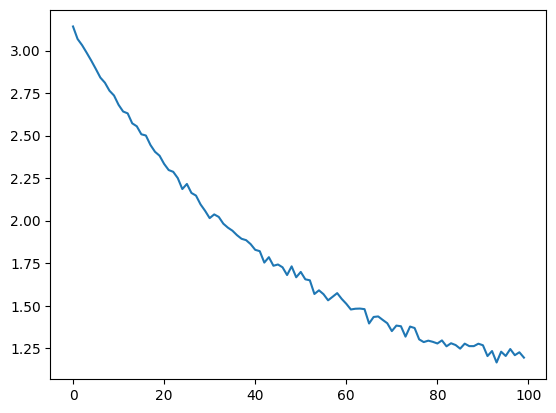

In [27]:
import matplotlib.pyplot as plt
plt.plot(saved_model['train_loss'])
plt.show()

In [31]:
from tqdm import tqdm

optimizer = torch.optim.Adam(v2t_model.parameters(), lr=10**-6, eps=1e-9)
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=target_tokenizer.token_to_id(
        '[PAD]'),label_smoothing=0.1).to(device)


loss_list_train=saved_model['train_loss']
# loss_list_train=[]
loss_list_val=[]
dis_loss=loss_list_train[-1]
for epoch in range(saved_model['epoch']+1,200):
# for epoch in range(100):
    torch._C._cuda_emptyCache()
    v2t_model.train()
    batch_iterator = tqdm(train_dataloader, desc=f"Processing Epoch {epoch:02d}")
    acc_loss=0
    for batch in batch_iterator:
    #             decoder_input = batch['decoder_input'].to(device)  # (B, seq_len)
    #             encoder_mask = batch['encoder_mask'].to(
    #                 device)  # (B, 1, 1, seq_len)
    #             decoder_mask = batch['decoder_mask'].to(
    #                 device)  # (B, 1, seq_len, seq_len)
                batch_iterator.set_postfix({"loss": f"{dis_loss:6.3f}"})
        
                src_video=batch['video'].to(device)
                decoder_input=batch['decoder_input'].to(device)
                decoder_mask=batch['decoder_mask'].to(device)
                
#                 # Run the tensors through the encoder, decoder and the projection layer
                encoder_output = v2t_model.encode(src_video=src_video)  # (B, seq_len, d_model)
                decoder_output = v2t_model.decode(encoder_output=encoder_output, src_mask=None,tgt=decoder_input, tgt_mask=decoder_mask) # (B, seq_len, d_model)
#                 # (B, seq_len, vocab_size)
                proj_output = v2t_model.project(decoder_output)
                
#                 # Compare the output with the label
                label = batch['label'].to(device)  # (B, seq_len)

#                 # Compute the loss using a simple cross entropy
                loss = loss_fn(proj_output.view(-1, target_tokenizer.get_vocab_size()), label.view(-1))
                
#                 # accumulated loss for every batch in a single epoch
                acc_loss+=loss.item()
                
        
                # Backpropagate the loss
                loss.backward()

                # Update the weights
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)
    
    
    
    loss_list_train.append(acc_loss/len(train_dataloader))
    dis_loss=(acc_loss/len(train_dataloader))
    
    run_validation(v2t_model,val_dataloader, target_tokenizer, 15 ,device,lambda msg: batch_iterator.write(msg))
    
    if (epoch+1)%10==0:
        torch.save({"model":v2t_model,
                    "train_loss":loss_list_train,
                    "epoch":epoch
                    },
                    f"{epoch}_mtrain.pt")
#     v2t_model.eval()
#     acc_loss=0
#     for batchv in val_dataloader:
#         with torch.no_grad():
#             logits=run_inference(model,batchv['video'].to(device))
#             label = batchv['label'].to(device)
            
#             loss = loss_fn(logits, label.view(-1))
#             acc_loss+=loss.item()
    
#     loss_list_val.append(acc_loss/len(val_dataloader))
    
#     print(f"Training Loss: {loss_list_train[-1]}")
#     print(f"Validation Loss: {loss_list_val[-1]}")
                

Processing Epoch 100:   0%|          | 0/11 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Processing Epoch 100: 100%|██████████| 11/11 [00:24<00:00,  2.20s/it, loss=1.195]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो साथी हरु भक्तपुर मा छन् ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.5714285969734192


/opt/conda/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `WordErrorRate` from `torchmetrics` was deprecated and will be removed in 2.0. Import `WordErrorRate` from `torchmetrics.text` instead.
  _future_warning(
Processing Epoch 101: 100%|██████████| 11/11 [00:23<00:00,  2.11s/it, loss=1.193]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो धेरै साथी हरु छन् ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.7894737124443054


Processing Epoch 102: 100%|██████████| 11/11 [00:24<00:00,  2.18s/it, loss=1.175]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.9473684430122375


Processing Epoch 103: 100%|██████████| 11/11 [00:22<00:00,  2.09s/it, loss=1.140]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.8999999761581421


Processing Epoch 104: 100%|██████████| 11/11 [00:23<00:00,  2.18s/it, loss=1.169]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: मेरो धेरै साथी हरु छन् ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो घर भक्तपुर मा छ ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
Word Error Rate:0.5555555820465088


Processing Epoch 105: 100%|██████████| 11/11 [00:23<00:00,  2.11s/it, loss=1.158]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: मेरो घर भक्तपुर मा छ ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.7894737124443054


Processing Epoch 106: 100%|██████████| 11/11 [00:24<00:00,  2.19s/it, loss=1.144]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: मेरो धेरै साथी हरु छन् ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.6315789222717285


Processing Epoch 107: 100%|██████████| 11/11 [00:22<00:00,  2.09s/it, loss=1.134]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: मेरो घर भक्तपुर मा छ ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो साथी हरु भक्तपुर मा छन् ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.4736842215061188


Processing Epoch 108: 100%|██████████| 11/11 [00:22<00:00,  2.06s/it, loss=1.109]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो घर भक्तपुर मा छ ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.75


Processing Epoch 109: 100%|██████████| 11/11 [00:23<00:00,  2.13s/it, loss=1.174]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: मेरो साथी हरु भक्तपुर मा छन् ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो साथी हरु भक्तपुर मा छन् ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.20000000298023224


Processing Epoch 110: 100%|██████████| 11/11 [00:24<00:00,  2.24s/it, loss=1.102]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: मेरो धेरै साथी हरु छन् ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
Word Error Rate:0.7777777910232544


Processing Epoch 111: 100%|██████████| 11/11 [00:23<00:00,  2.17s/it, loss=1.124]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: मेरो घर भक्तपुर मा छ ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: मेरो धेरै साथी हरु छन् ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: मेरो साथी हरु भक्तपुर मा छन् ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
Word Error Rate:0.8947368264198303


Processing Epoch 112: 100%|██████████| 11/11 [00:23<00:00,  2.17s/it, loss=1.110]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: मेरो घर भक्तपुर मा छ ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: मेरो घर भक्तपुर मा छ ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: मेरो धेरै साथी हरु छन् ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
Word Error Rate:0.8888888955116272


Processing Epoch 113: 100%|██████████| 11/11 [00:24<00:00,  2.19s/it, loss=1.137]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: मेरो धेरै साथी हरु छन् ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
Word Error Rate:0.7777777910232544


Processing Epoch 114: 100%|██████████| 11/11 [00:23<00:00,  2.13s/it, loss=1.126]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: मेरो धेरै साथी हरु छन् ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: मेरो धेरै साथी हरु छन् ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
Word Error Rate:0.6315789222717285


Processing Epoch 115: 100%|██████████| 11/11 [00:22<00:00,  2.07s/it, loss=1.121]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: मेरो धेरै साथी हरु छन् ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
Word Error Rate:0.7777777910232544


Processing Epoch 116: 100%|██████████| 11/11 [00:22<00:00,  2.08s/it, loss=1.093]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: मेरो साथी हरु भक्तपुर मा छन् ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.5263158082962036


Processing Epoch 117: 100%|██████████| 11/11 [00:23<00:00,  2.15s/it, loss=1.161]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो घर भक्तपुर मा छ ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.8333333134651184


Processing Epoch 118: 100%|██████████| 11/11 [00:23<00:00,  2.09s/it, loss=1.101]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: मेरो घर भक्तपुर मा छ ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो घर भक्तपुर मा छ ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.6315789222717285


Processing Epoch 119: 100%|██████████| 11/11 [00:22<00:00,  2.07s/it, loss=1.077]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: मेरो घर भक्तपुर मा छ ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो धेरै साथी हरु छन् ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.31578946113586426


Processing Epoch 120: 100%|██████████| 11/11 [00:23<00:00,  2.12s/it, loss=1.108]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: मेरो साथी हरु भक्तपुर मा छन् ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.6000000238418579


Processing Epoch 121: 100%|██████████| 11/11 [00:24<00:00,  2.18s/it, loss=1.071]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: मेरो घर भक्तपुर मा छ ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो साथी हरु भक्तपुर मा छन् ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो घर भक्तपुर मा छ ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.31578946113586426


Processing Epoch 122: 100%|██████████| 11/11 [00:23<00:00,  2.12s/it, loss=1.052]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो घर भक्तपुर मा छ ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो साथी हरु भक्तपुर मा छन् ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.44999998807907104


Processing Epoch 123: 100%|██████████| 11/11 [00:23<00:00,  2.11s/it, loss=1.079]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो धेरै साथी हरु छन् ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.4736842215061188


Processing Epoch 124: 100%|██████████| 11/11 [00:23<00:00,  2.10s/it, loss=1.073]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: मेरो घर भक्तपुर मा छ ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो घर भक्तपुर मा छ ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.7368420958518982


Processing Epoch 125: 100%|██████████| 11/11 [00:23<00:00,  2.17s/it, loss=1.025]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: मेरो घर भक्तपुर मा छ ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो धेरै साथी हरु छन् ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.6666666865348816


Processing Epoch 126: 100%|██████████| 11/11 [00:23<00:00,  2.13s/it, loss=1.099]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो धेरै साथी हरु छन् ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
Word Error Rate:0.4736842215061188


Processing Epoch 127: 100%|██████████| 11/11 [00:23<00:00,  2.09s/it, loss=1.063]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: मेरो घर भक्तपुर मा छ ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.7894737124443054


Processing Epoch 128: 100%|██████████| 11/11 [00:23<00:00,  2.13s/it, loss=1.072]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: मेरो घर भक्तपुर मा छ ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो साथी हरु भक्तपुर मा छन् ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: मेरो घर भक्तपुर मा छ ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.6315789222717285


Processing Epoch 129: 100%|██████████| 11/11 [00:23<00:00,  2.18s/it, loss=1.046]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: मेरो धेरै साथी हरु छन् ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो साथी हरु भक्तपुर मा छन् ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.75


Processing Epoch 130: 100%|██████████| 11/11 [00:23<00:00,  2.10s/it, loss=1.027]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: मेरो साथी हरु भक्तपुर मा छन् ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो घर भक्तपुर मा छ ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.75


Processing Epoch 131: 100%|██████████| 11/11 [00:22<00:00,  2.07s/it, loss=1.009]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: मेरो साथी हरु भक्तपुर मा छन् ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: मेरो धेरै साथी हरु छन् ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
Word Error Rate:0.6000000238418579


Processing Epoch 132: 100%|██████████| 11/11 [00:22<00:00,  2.05s/it, loss=1.034]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो घर भक्तपुर मा छ ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो साथी हरु भक्तपुर मा छन् ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.4736842215061188


Processing Epoch 133: 100%|██████████| 11/11 [00:24<00:00,  2.22s/it, loss=1.082]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: मेरो साथी हरु भक्तपुर मा छन् ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: मेरो घर भक्तपुर मा छ ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.44999998807907104


Processing Epoch 134: 100%|██████████| 11/11 [00:22<00:00,  2.08s/it, loss=1.019]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.8999999761581421


Processing Epoch 135: 100%|██████████| 11/11 [00:23<00:00,  2.12s/it, loss=1.051]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: मेरो धेरै साथी हरु छन् ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो साथी हरु भक्तपुर मा छन् ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.3684210479259491


Processing Epoch 136: 100%|██████████| 11/11 [00:23<00:00,  2.11s/it, loss=1.029]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो साथी हरु भक्तपुर मा छन् ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.5714285969734192


Processing Epoch 137: 100%|██████████| 11/11 [00:24<00:00,  2.20s/it, loss=1.031]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: मेरो धेरै साथी हरु छन् ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
Word Error Rate:0.5263158082962036


Processing Epoch 138: 100%|██████████| 11/11 [00:23<00:00,  2.11s/it, loss=1.018]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: मेरो धेरै साथी हरु छन् ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: मेरो साथी हरु भक्तपुर मा छन् ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
Word Error Rate:0.6000000238418579


Processing Epoch 139: 100%|██████████| 11/11 [00:23<00:00,  2.16s/it, loss=1.025]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: मेरो साथी हरु भक्तपुर मा छन् ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो साथी हरु भक्तपुर मा छन् ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.30000001192092896


Processing Epoch 140: 100%|██████████| 11/11 [00:23<00:00,  2.15s/it, loss=1.032]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: मेरो घर भक्तपुर मा छ ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो धेरै साथी हरु छन् ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.6666666865348816


Processing Epoch 141: 100%|██████████| 11/11 [00:22<00:00,  2.06s/it, loss=1.031]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: मेरो साथी हरु भक्तपुर मा छन् ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो धेरै साथी हरु छन् ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.4736842215061188


Processing Epoch 142: 100%|██████████| 11/11 [00:22<00:00,  2.07s/it, loss=1.038]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.9473684430122375


Processing Epoch 143: 100%|██████████| 11/11 [00:22<00:00,  2.04s/it, loss=0.974]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो घर भक्तपुर मा छ ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो धेरै साथी हरु छन् ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.6315789222717285


Processing Epoch 144: 100%|██████████| 11/11 [00:23<00:00,  2.14s/it, loss=1.031]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो घर भक्तपुर मा छ ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.7894737124443054


Processing Epoch 145: 100%|██████████| 11/11 [00:22<00:00,  2.08s/it, loss=1.001]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: मेरो घर भक्तपुर मा छ ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो घर भक्तपुर मा छ ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: मेरो घर भक्तपुर मा छ ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.6111111044883728


Processing Epoch 146: 100%|██████████| 11/11 [00:22<00:00,  2.06s/it, loss=1.005]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
Word Error Rate:0.7777777910232544


Processing Epoch 147: 100%|██████████| 11/11 [00:22<00:00,  2.03s/it, loss=1.004]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: मेरो धेरै साथी हरु छन् ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो घर भक्तपुर मा छ ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
Word Error Rate:0.6666666865348816


Processing Epoch 148: 100%|██████████| 11/11 [00:23<00:00,  2.17s/it, loss=0.988]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
Word Error Rate:0.6666666865348816


Processing Epoch 149: 100%|██████████| 11/11 [00:23<00:00,  2.09s/it, loss=1.038]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: मेरो साथी हरु भक्तपुर मा छन् ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
Word Error Rate:0.5


Processing Epoch 150: 100%|██████████| 11/11 [00:22<00:00,  2.07s/it, loss=1.000]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो घर भक्तपुर मा छ ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो धेरै साथी हरु छन् ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
Word Error Rate:0.8333333134651184


Processing Epoch 151: 100%|██████████| 11/11 [00:22<00:00,  2.05s/it, loss=1.045]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: मेरो घर भक्तपुर मा छ ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो धेरै साथी हरु छन् ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.6666666865348816


Processing Epoch 152: 100%|██████████| 11/11 [00:23<00:00,  2.13s/it, loss=1.031]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो साथी हरु भक्तपुर मा छन् ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो साथी हरु भक्तपुर मा छन् ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.2857142984867096


Processing Epoch 153: 100%|██████████| 11/11 [00:23<00:00,  2.10s/it, loss=1.014]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: मेरो धेरै साथी हरु छन् ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो धेरै साथी हरु छन् ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.6315789222717285


Processing Epoch 154: 100%|██████████| 11/11 [00:22<00:00,  2.08s/it, loss=0.973]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: मेरो घर भक्तपुर मा छ ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.7894737124443054


Processing Epoch 155: 100%|██████████| 11/11 [00:22<00:00,  2.08s/it, loss=0.991]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो घर भक्तपुर मा छ ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
Word Error Rate:0.5789473652839661


Processing Epoch 156: 100%|██████████| 11/11 [00:22<00:00,  2.09s/it, loss=0.979]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो साथी हरु भक्तपुर मा छन् ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.5714285969734192


Processing Epoch 157: 100%|██████████| 11/11 [00:22<00:00,  2.02s/it, loss=0.967]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: मेरो घर भक्तपुर मा छ ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो धेरै साथी हरु छन् ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
Word Error Rate:0.7222222089767456


Processing Epoch 158: 100%|██████████| 11/11 [00:22<00:00,  2.05s/it, loss=0.993]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो साथी हरु भक्तपुर मा छन् ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.6000000238418579


Processing Epoch 159: 100%|██████████| 11/11 [00:23<00:00,  2.11s/it, loss=1.020]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो धेरै साथी हरु छन् ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.7894737124443054


Processing Epoch 160: 100%|██████████| 11/11 [00:24<00:00,  2.21s/it, loss=0.997]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: मेरो घर भक्तपुर मा छ ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.75


Processing Epoch 161: 100%|██████████| 11/11 [00:23<00:00,  2.15s/it, loss=0.993]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो घर भक्तपुर मा छ ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो साथी हरु भक्तपुर मा छन् ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.4736842215061188


Processing Epoch 162: 100%|██████████| 11/11 [00:23<00:00,  2.15s/it, loss=0.953]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो साथी हरु भक्तपुर मा छन् ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.6000000238418579


Processing Epoch 163: 100%|██████████| 11/11 [00:23<00:00,  2.10s/it, loss=0.976]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो साथी हरु भक्तपुर मा छन् ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.6000000238418579


Processing Epoch 164: 100%|██████████| 11/11 [00:22<00:00,  2.08s/it, loss=0.993]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो साथी हरु भक्तपुर मा छन् ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो घर भक्तपुर मा छ ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.4736842215061188


Processing Epoch 165: 100%|██████████| 11/11 [00:23<00:00,  2.12s/it, loss=0.992]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो धेरै साथी हरु छन् ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.75


Processing Epoch 166: 100%|██████████| 11/11 [00:22<00:00,  2.07s/it, loss=0.941]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: मेरो धेरै साथी हरु छन् ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो साथी हरु भक्तपुर मा छन् ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो घर भक्तपुर मा छ ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.31578946113586426


Processing Epoch 167: 100%|██████████| 11/11 [00:22<00:00,  2.08s/it, loss=0.969]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.9473684430122375


Processing Epoch 168: 100%|██████████| 11/11 [00:23<00:00,  2.11s/it, loss=0.961]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो धेरै साथी हरु छन् ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.7894737124443054


Processing Epoch 169: 100%|██████████| 11/11 [00:23<00:00,  2.09s/it, loss=0.968]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: मेरो घर भक्तपुर मा छ ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो धेरै साथी हरु छन् ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.6315789222717285


Processing Epoch 170: 100%|██████████| 11/11 [00:23<00:00,  2.17s/it, loss=0.960]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: मेरो घर भक्तपुर मा छ ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: मेरो साथी हरु भक्तपुर मा छन् ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: मेरो धेरै साथी हरु छन् ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
Word Error Rate:0.8947368264198303


Processing Epoch 171: 100%|██████████| 11/11 [00:23<00:00,  2.17s/it, loss=0.931]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: मेरो धेरै साथी हरु छन् ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
Word Error Rate:0.5263158082962036


Processing Epoch 172: 100%|██████████| 11/11 [00:22<00:00,  2.09s/it, loss=0.950]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: मेरो साथी हरु भक्तपुर मा छन् ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: मेरो धेरै साथी हरु छन् ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
Word Error Rate:0.6000000238418579


Processing Epoch 173: 100%|██████████| 11/11 [00:23<00:00,  2.11s/it, loss=0.970]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: मेरो धेरै साथी हरु छन् ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
Word Error Rate:0.5263158082962036


Processing Epoch 174: 100%|██████████| 11/11 [00:23<00:00,  2.11s/it, loss=0.922]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: मेरो धेरै साथी हरु छन् ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: मेरो धेरै साथी हरु छन् ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: मेरो धेरै साथी हरु छन् ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
Word Error Rate:1.0


Processing Epoch 175: 100%|██████████| 11/11 [00:23<00:00,  2.13s/it, loss=0.971]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: मेरो धेरै साथी हरु छन् ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: मेरो धेरै साथी हरु छन् ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
Word Error Rate:0.8888888955116272


Processing Epoch 176: 100%|██████████| 11/11 [00:23<00:00,  2.09s/it, loss=0.969]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: मेरो साथी हरु भक्तपुर मा छन् ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो साथी हरु भक्तपुर मा छन् ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
Word Error Rate:0.8571428656578064


Processing Epoch 177: 100%|██████████| 11/11 [00:23<00:00,  2.11s/it, loss=0.930]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
Word Error Rate:0.20000000298023224


Processing Epoch 178: 100%|██████████| 11/11 [00:22<00:00,  2.07s/it, loss=0.917]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: मेरो साथी हरु भक्तपुर मा छन् ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
Word Error Rate:0.7368420958518982


Processing Epoch 179: 100%|██████████| 11/11 [00:23<00:00,  2.12s/it, loss=0.926]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: मेरो साथी हरु भक्तपुर मा छन् ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
Word Error Rate:0.5


Processing Epoch 180: 100%|██████████| 11/11 [00:23<00:00,  2.13s/it, loss=0.938]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: मेरो साथी हरु भक्तपुर मा छन् ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
Word Error Rate:0.7368420958518982


Processing Epoch 181: 100%|██████████| 11/11 [00:23<00:00,  2.15s/it, loss=0.940]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: मेरो धेरै साथी हरु छन् ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: मेरो घर भक्तपुर मा छ ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
Word Error Rate:0.8333333134651184


Processing Epoch 182: 100%|██████████| 11/11 [00:24<00:00,  2.18s/it, loss=0.947]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: मेरो साथी हरु भक्तपुर मा छन् ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: मेरो घर भक्तपुर मा छ ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: मेरो धेरै साथी हरु छन् ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
Word Error Rate:0.8947368264198303


Processing Epoch 183: 100%|██████████| 11/11 [00:23<00:00,  2.13s/it, loss=0.926]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: मेरो साथी हरु भक्तपुर मा छन् ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
Word Error Rate:0.7368420958518982


Processing Epoch 184: 100%|██████████| 11/11 [00:23<00:00,  2.16s/it, loss=0.934]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: मेरो धेरै साथी हरु छन् ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: मेरो धेरै साथी हरु छन् ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
Word Error Rate:0.8888888955116272


Processing Epoch 185: 100%|██████████| 11/11 [00:23<00:00,  2.15s/it, loss=0.924]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: मेरो धेरै साथी हरु छन् ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
Word Error Rate:0.30000001192092896


Processing Epoch 186: 100%|██████████| 11/11 [00:23<00:00,  2.15s/it, loss=0.935]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: मेरो साथी हरु भक्तपुर मा छन् ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: मेरो साथी हरु भक्तपुर मा छन् ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
Word Error Rate:0.5714285969734192


Processing Epoch 187: 100%|██████████| 11/11 [00:23<00:00,  2.10s/it, loss=0.958]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: मेरो धेरै साथी हरु छन् ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: मेरो धेरै साथी हरु छन् ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
Word Error Rate:0.6315789222717285


Processing Epoch 188: 100%|██████████| 11/11 [00:22<00:00,  2.09s/it, loss=0.941]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: मेरो धेरै साथी हरु छन् ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: म घर मा धेरै काम गर्छु ।
--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.44999998807907104


Processing Epoch 189: 100%|██████████| 11/11 [00:23<00:00,  2.09s/it, loss=0.970]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: मेरो घर भक्तपुर मा छ ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो धेरै साथी हरु छन् ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.6315789222717285


Processing Epoch 190: 100%|██████████| 11/11 [00:24<00:00,  2.23s/it, loss=0.956]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो धेरै साथी हरु छन् ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो घर भक्तपुर मा छ ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.6315789222717285


Processing Epoch 191: 100%|██████████| 11/11 [00:23<00:00,  2.10s/it, loss=0.953]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो साथी हरु भक्तपुर मा छन् ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो धेरै साथी हरु छन् ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.44999998807907104


Processing Epoch 192: 100%|██████████| 11/11 [00:22<00:00,  2.08s/it, loss=0.932]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो धेरै साथी हरु छन् ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.75


Processing Epoch 193: 100%|██████████| 11/11 [00:23<00:00,  2.12s/it, loss=0.938]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो घर भक्तपुर मा छ ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.7894737124443054


Processing Epoch 194: 100%|██████████| 11/11 [00:24<00:00,  2.20s/it, loss=0.912]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: मेरो साथी हरु भक्तपुर मा छन् ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.6000000238418579


Processing Epoch 195: 100%|██████████| 11/11 [00:22<00:00,  2.09s/it, loss=0.955]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो धेरै साथी हरु छन् ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो साथी हरु भक्तपुर मा छन् ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.4736842215061188


Processing Epoch 196: 100%|██████████| 11/11 [00:23<00:00,  2.10s/it, loss=0.936]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.8999999761581421


Processing Epoch 197: 100%|██████████| 11/11 [00:23<00:00,  2.13s/it, loss=0.961]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: मेरो साथी हरु भक्तपुर मा छन् ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.6000000238418579


Processing Epoch 198: 100%|██████████| 11/11 [00:23<00:00,  2.16s/it, loss=0.931]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: म संग धेरै पैसा छैन ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: म घर मा धेरै काम गर्छु ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.9473684430122375


Processing Epoch 199: 100%|██████████| 11/11 [00:22<00:00,  2.06s/it, loss=0.936]
stty: 'standard input': Inappropriate ioctl for device


--------------------------------------------------------------------------------
    TARGET: मेरो घर भक्तपुर मा छ ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो साथी हरु भक्तपुर मा छन् ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
    TARGET: मेरो साथी हरु भक्तपुर मा छन् ।
 PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
--------------------------------------------------------------------------------
Word Error Rate:0.15000000596046448


In [ ]:
# torch.save(v2t_model,"1_e_train.pt")

In [ ]:
# v2t_model=torch.load('/kaggle/input/save-model/1_e_train.pt',map_location=torch.device('cpu'))

# **Running Tests**

## Plot Each Frames Extracted from the Video

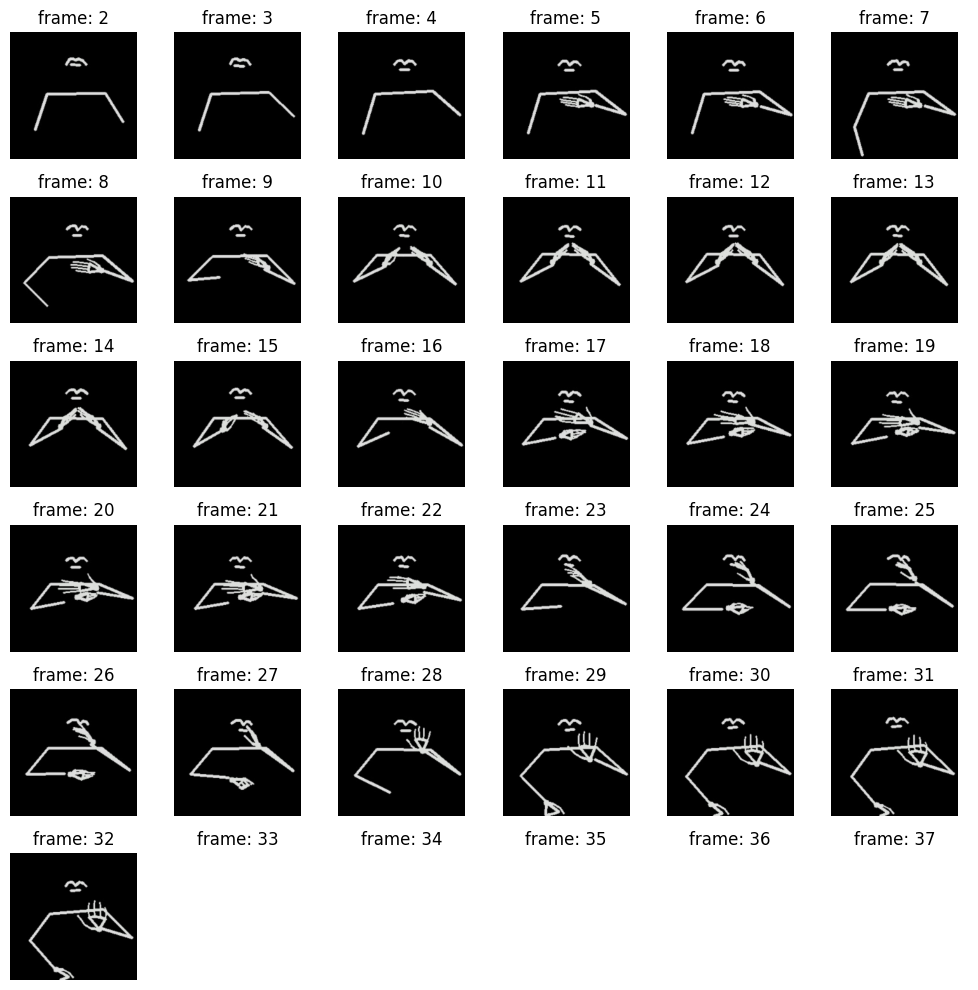

In [107]:
import matplotlib.pyplot as plt

video=next(iter(train_dataloader))

# Create subplots
fig, axs = plt.subplots(6, 6, figsize=(10, 10))

# Plot images
f=0
for i in range(6):
    for j in range(6):
        f+=1
        if f<32:
          im=video['video'].permute(0,2,3,4,1)[0,f,:,:,:]
          axs[i, j].imshow(im)
        axs[i, j].set_title(f'frame: {f+1}')
        axs[i, j].axis('off')  # Hide axis
plt.tight_layout()
plt.show()

In [104]:
video['tgt_text']

['मेरो घर भक्तपुर मा छ ।']

# **Inference on Single Video**

In [33]:
saved_model=torch.load('/kaggle/working/199_mtrain.pt')
v2t_model=saved_model['model'].to(device)

In [81]:
def run_inference(model, video, tokenizer_tgt, max_len, device):
    model.eval()

    source_texts = []
    expected = []
    predicted = []

    with torch.no_grad():

        encoder_input = video['video'][0].unsqueeze(0).to(device)  # (b, seq_len)

        # check that the batch size is 1
        assert encoder_input.size(
            0) == 1, "Batch size must be 1 for validation"

        model_out = greedy_decode(
            model, encoder_input, None, tokenizer_tgt, max_len, device)

        target_text = video["tgt_text"][0]
        model_out_text = tokenizer_tgt.decode(
            model_out.detach().cpu().numpy())

#             source_texts.append(source_text)
        expected.append(target_text)
        predicted.append(model_out_text)

        # Print the source, target and model output
        print('-----------------------------')
        print(f"TARGET: {target_text}")
        print(f"PREDICTED: {model_out_text}")

        # Compute the word error rate   
        metric = torchmetrics.WordErrorRate()
        wer = metric(predicted, expected)
        print(f"Word Error Rate:{wer}")

In [110]:
video=next(iter(train_dataloader))
run_inference(model=v2t_model, video=video, tokenizer_tgt=target_tokenizer, max_len=15, device=device)

-----------------------------
TARGET: मेरो साथी हरु भक्तपुर मा छन् ।
PREDICTED: मेरो साथी हरु भक्तपुर मा छन् ।
Word Error Rate:0.0
